## --- Generate text with a recurrent neural network (Pytorch) ---
### (Mostly Read & Run)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [1]:
!curl -O https://thome.isir.upmc.fr/classes/RITAL/input.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 10 1089k   10  111k    0     0  66801      0  0:00:16  0:00:01  0:00:15 66846
 26 1089k   26  287k    0     0   131k      0  0:00:08  0:00:02  0:00:06  131k
 38 1089k   38  415k    0     0   130k      0  0:00:08  0:00:03  0:00:05  130k
 61 1089k   61  671k    0     0   160k      0  0:00:06  0:00:04  0:00:02  160k
 83 1089k   83  911k    0     0   176k      0  0:00:06  0:00:05  0:00:01  183k
100 1089k  100 1089k    0     0   191k      0  0:00:05  0:00:05 --:--:--  245k


In [1]:
!pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/58/b8/51b956c2da9729390a3080397cd2f31171394543af7746681466e372f69a/torch-2.2.0-cp311-cp311-win_amd64.whl.metadata
  Using cached torch-2.2.0-cp311-cp311-win_amd64.whl.metadata (26 kB)
Using cached torch-2.2.0-cp311-cp311-win_amd64.whl (198.6 MB)


In [2]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('./input.txt').read()) #clean text => only ascii
file_len = len(file)
print('file_len =', file_len)


file_len = 1115394


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk`
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [4]:
import time, math


#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor


#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)

    return inp, target

print(random_training_set(10,4))  ## should return 8 chunks of 10 letters.

(tensor([[94, 15, 10, 29, 17, 14, 27, 94, 68, 28],
        [13, 73, 94, 28, 17, 14, 94, 28, 29, 27],
        [28, 14, 27, 31, 14, 13, 96, 58, 18, 29],
        [39, 30, 20, 14, 28, 94, 24, 15, 94, 54]]), tensor([[15, 10, 29, 17, 14, 27, 94, 68, 28, 12],
        [73, 94, 28, 17, 14, 94, 28, 29, 27, 30],
        [14, 27, 31, 14, 13, 96, 58, 18, 29, 17],
        [30, 20, 14, 28, 94, 24, 15, 94, 54, 24]]))


## The actual RNN model (only thing to complete):

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)

```
nn.Embedding(len_dic,size_vec)
```
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
```
nn.RNN(in_size,out_size) or nn.GRU() or nn.LSTM() => rnn_cell parameter
```
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)

```
nn.Linear(in_size,out_size)
```
=> Complete the `init` function code

In [5]:
import torch.nn.functional as f

class RNN(nn.Module):

    def __init__(self, n_char, hidden_size, output_size, n_layers=1,rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()

        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)
        self.embed = nn.Embedding(self.n_char,self.hidden_size)

        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)
        self.rnn = nn.RNN(self.n_char,self.output_size)

        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)
        self.predict = nn.Linear(self.n_char,self.output_size)

    def forward(self, input):
        """
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.rnn(input)
        output = self.predict(f.tanh(output))
        return output

    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden


## Text generation function

Sample text from the model

In [6]:
def generate(model,prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)

    #print(hidden.size())
    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        #print(output_dist)
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        prime_input = torch.cat([prime_input,char_tensor(predicted_char).squeeze(0)])

    return predicted



## Training loop for net

In [7]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 20000 # iterations
print_every = 100
plot_every = 10
hidden_size = 100 #size of hidden layer
#n_layers = 5
lr = 0.005 #learning rate
batch_size = 16 # nbnb of chunks in a batch 
chunk_len = 80 #length of characters in a chunk

####

model = RNN(n_characters, hidden_size, n_characters, n_layers) #create model (remove n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad()

    # predict output
    output = model(inp)

    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1))

    #compute gradients and backpropagate
    loss.backward()
    model_optimizer.step()

    return loss.data.item()



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')



    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 2s (100 0%) 2.4602]
Whe se
Thit thimy f ted,


A:
Mowasend t mardinoung cithamr,
I he'dthe wave an windeadiyour isoral yon 

 5s (200 1%) 2.4423]
Wh youn.
'd ind ay f pyou m!
Win
Th te bour hearanaris sto, f foorerursheeeray fors t bofar t s t wndr 

 8s (300 1%) 2.5202]
Whyomoroulo t t, d s ss t ar I atheamby y be an at thand heata y mese the thouroust owis thericonout
W 

 10s (400 2%) 2.4376]
Whence f thef aghe t wst be t d merd athe Anee he het ators seea ape cee ave rr, ato d y ineree g angu 

 13s (500 2%) 2.5075]
Whe f pe stugr.

Thean naver Asthinour terofthin:

Byoie sstofoud oromet tind he frome t s
An in thif  

 15s (600 3%) 2.4537]
Whereis trin ce h keancoupis t is marof er urideled th ar?
And t e ofoun aringh, t y th ping ithilitha 

 18s (700 3%) 2.4869]
Whareat'sas s wad ladestisend sionisckent thicumy'd t,
Th lloke, my iverinomarerd-d ser LLENT:
Ange wi 

 20s (800 4%) 2.5254]
Whore eratonots ot pulanteld d theey t mures harthin t the fineert.
LOUK:
G wared me plor ti

## Visualize loss

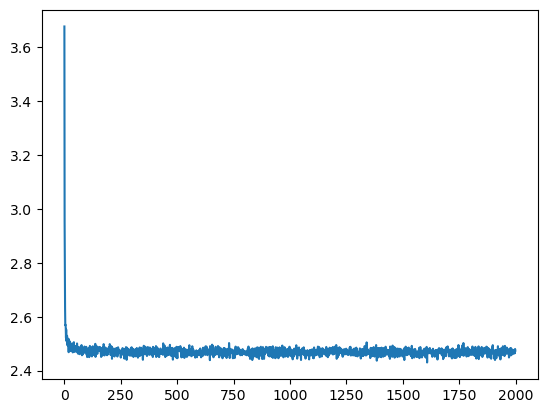

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

In [9]:
print(generate(model,'T', 200, temperature=1))
print("----")
print(generate(model,'Th', 200, temperature=0.8))
print("----")

print(generate(model,'Th', 200, temperature=0.5))
print("----")

print(generate(model,'Th', 200, temperature=0.3))
print("----")

print(generate(model,'Th', 200, temperature=0.1))

TRD:
PORUCENeristhiof w h n for
I:
CO: anysifathestoow heo y narewhersedsurnggedeangeais, s
Anond
UCUSind the,
Rle s s orthasour mey wiso tes, icod sthay inoo'sormby Shar, kngrs eco par ozemithitht the
----
Ththa calis


UCETRI I and betisho s vicearmouthinthithadwies t:
HAn ch mongercareateerd bule t, s s silithat f ithavim pod
HOUNGO, asthanomseeder t

Susillou ious ped watow th therome pour s. fintarme 
----
Thar s l te is ous s athe aivie the s wishenong mathou s ome n come thinghay this can thow t than thin ar ingen ar, t hes as is benou s thete t thisour th we the mas theer bu y y t y thalan s, t me mout
----
The this t tharof the the the the the the s th the the t the me withe sthe at the the the thour that thin the the thoure t thour the wiser wind the winge the the the t he s the wis s as the ther the the
----
The the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the thathe the the th